In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]

# Elimina la columna 'Date' de 'all_data'
all_data.drop('Date', axis=1, inplace=True)


[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Instanciar el modelo ClimateVR con los datos
vr_model = ClimateVR(all_data)

# Optimizar el número de retardos usando Optuna
optimal_maxlags, optimal_rmse = vr_model.optimize_maxlags(all_data=all_data, n_trials=100)
print(f'Número óptimo de retardos: {optimal_maxlags}')
print(f'RMSE óptimo: {optimal_rmse}')

# Ajustar el modelo VR con el número óptimo de retardos
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=len(all_data))

Número óptimo de retardos: 6
RMSE óptimo: 6663.531111585044


In [4]:
predict

array([[-3.72273145e-02, -2.04622777e-02, -5.49185193e-02, ...,
         4.65489580e+04,  5.24000000e+00,  5.45907000e+02],
       [-3.29269845e-02, -2.45955667e-02, -5.70455584e-02, ...,
         4.66708000e+04,  5.25000000e+00,  5.47719000e+02],
       [-6.61961448e-02, -7.69780263e-03,  7.99097286e-02, ...,
         4.66708000e+04,  5.25000000e+00,  5.47719000e+02],
       ...,
       [-1.85431634e-02, -1.24793192e-01,  5.18796731e-02, ...,
         5.65383480e+04,  1.04400000e+01,  6.19370000e+02],
       [-5.12862742e-02,  3.65907761e-02,  9.68874113e-02, ...,
         5.65383480e+04,  1.04400000e+01,  6.19370000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.82691740e+04,  5.22000000e+00,  3.09685000e+02]])

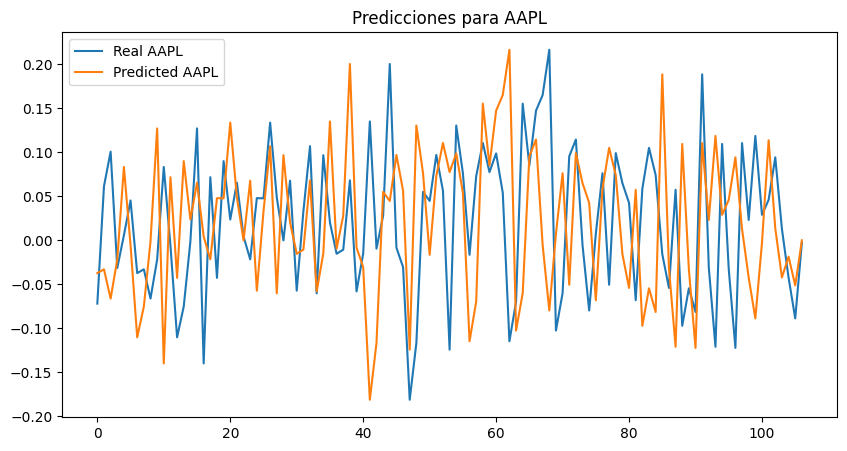

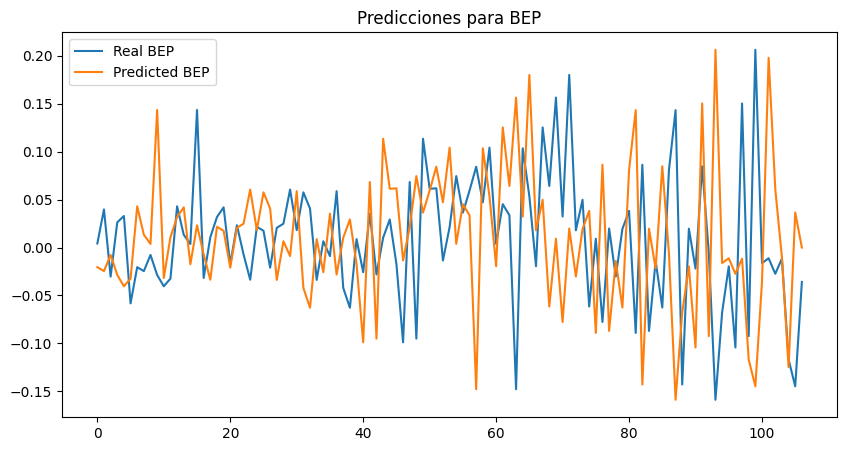

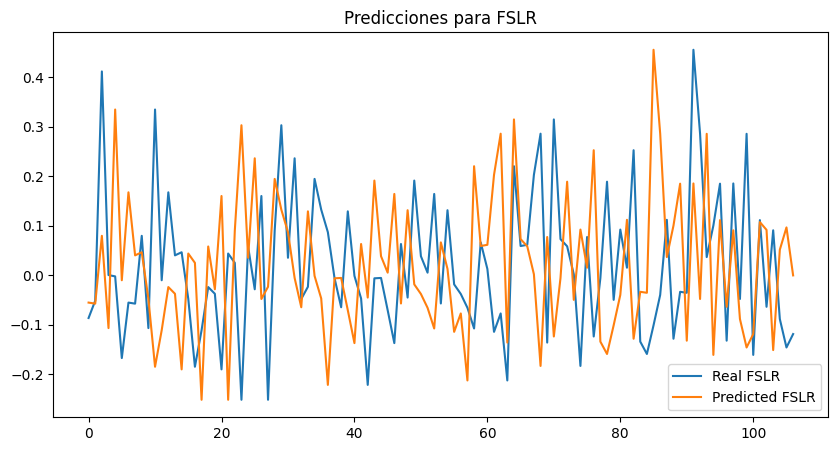

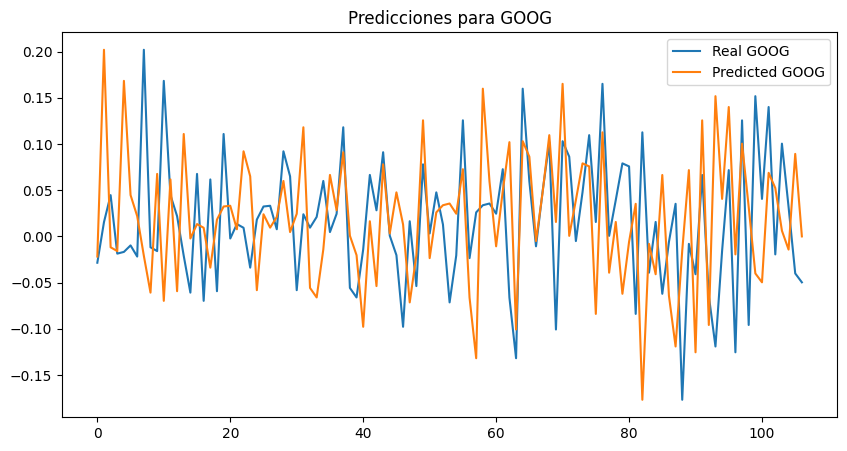

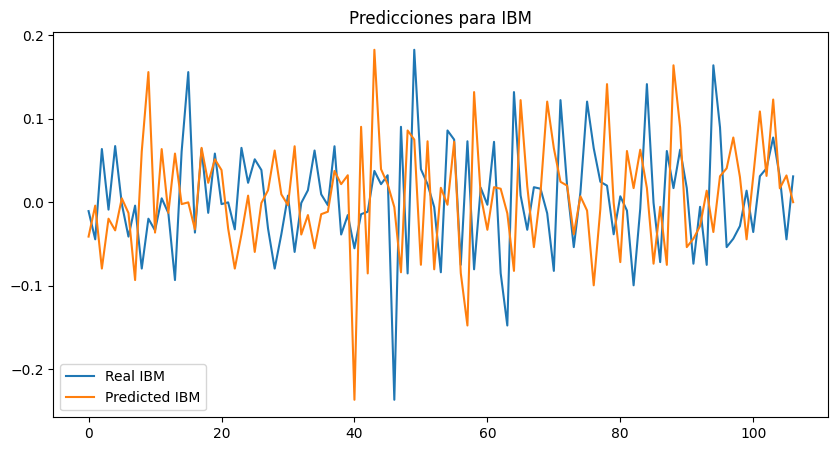

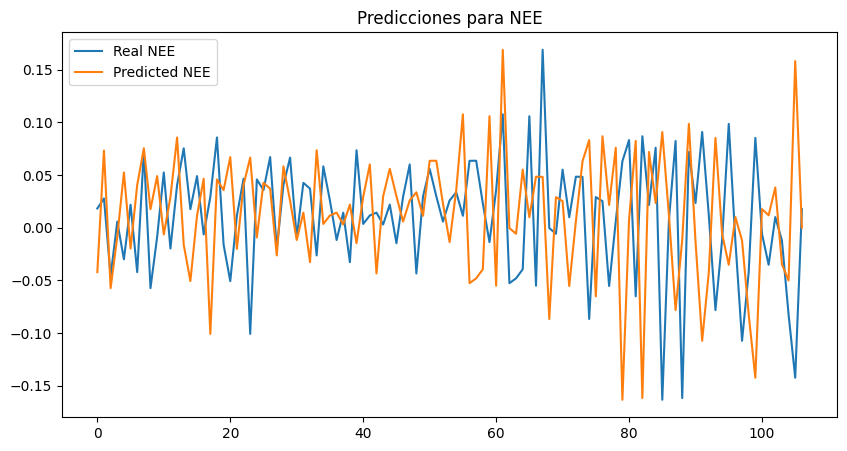

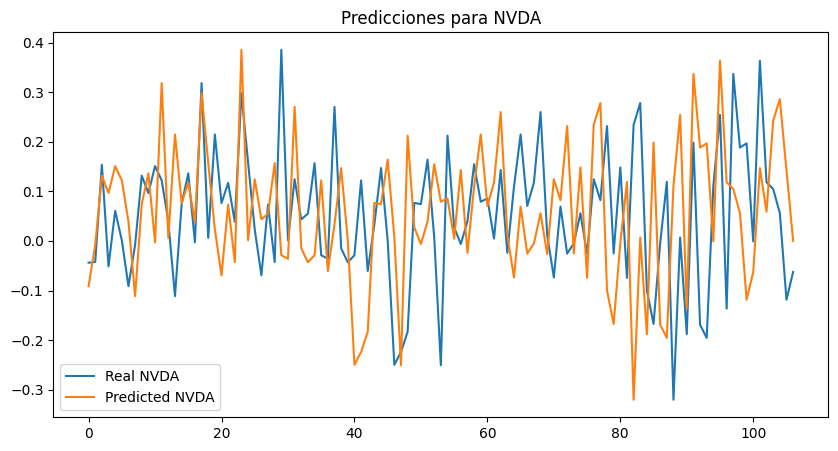

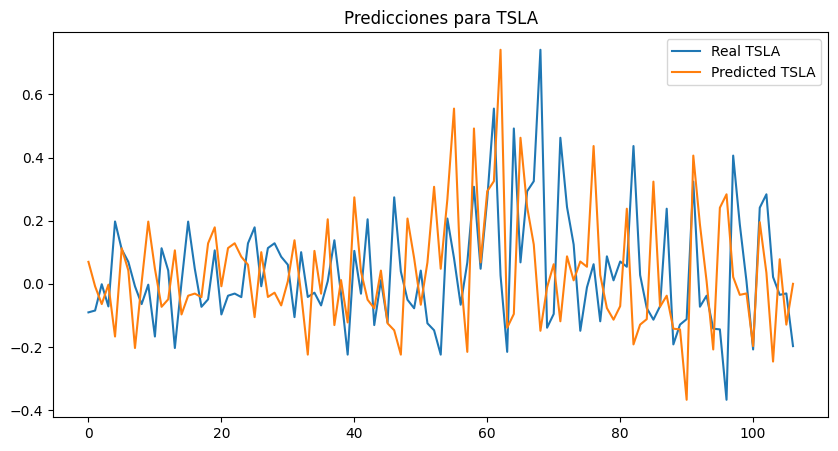

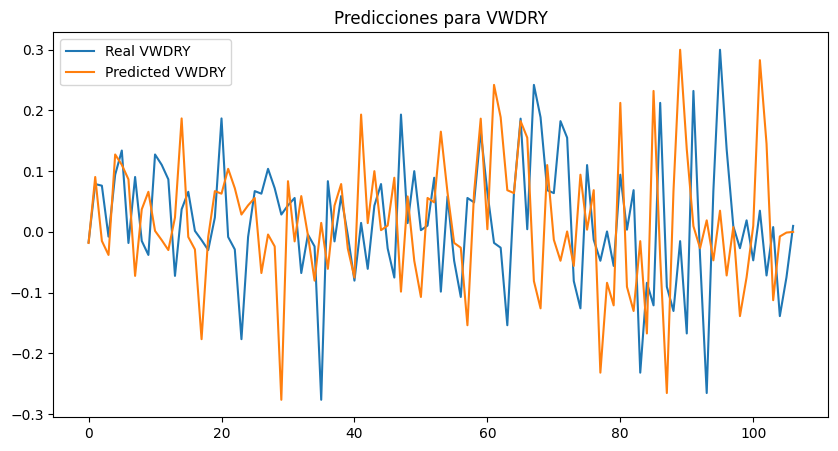

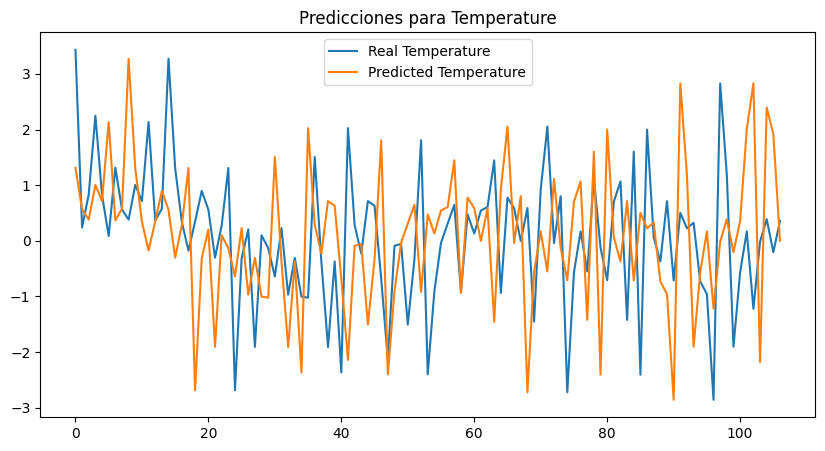

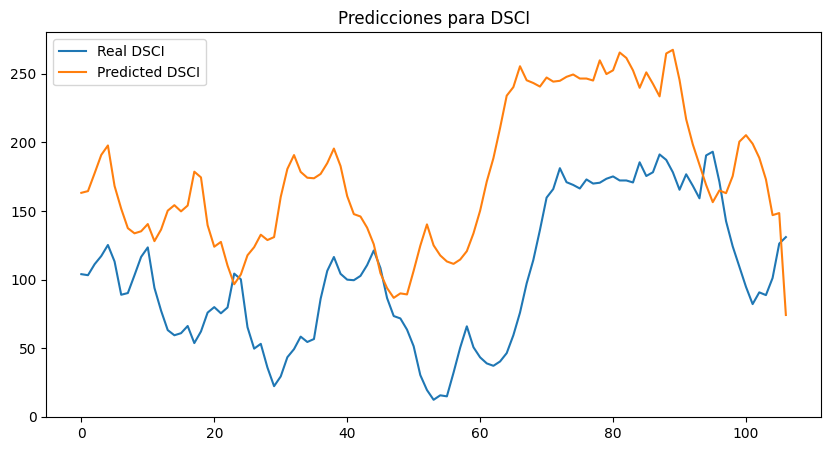

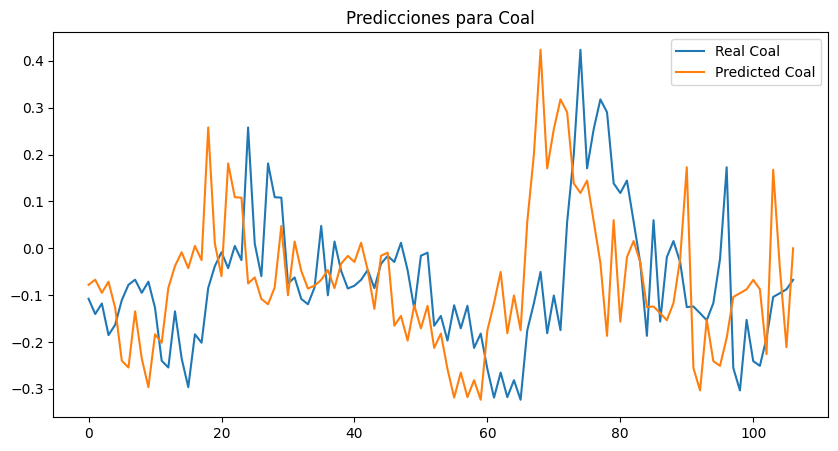

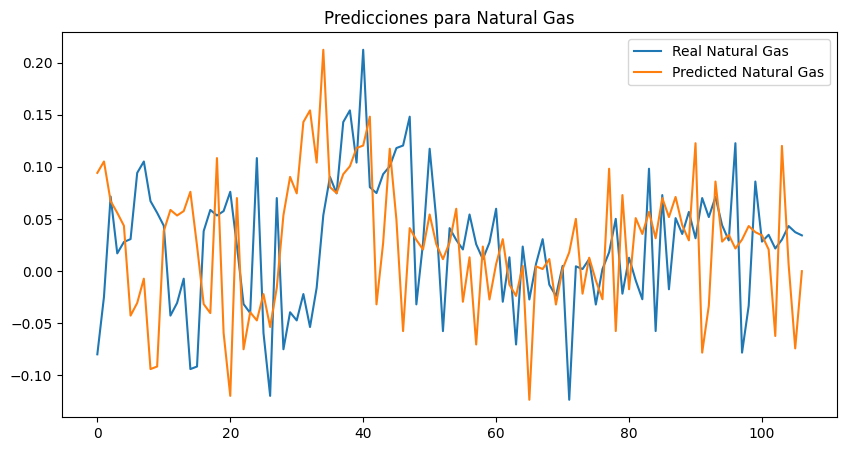

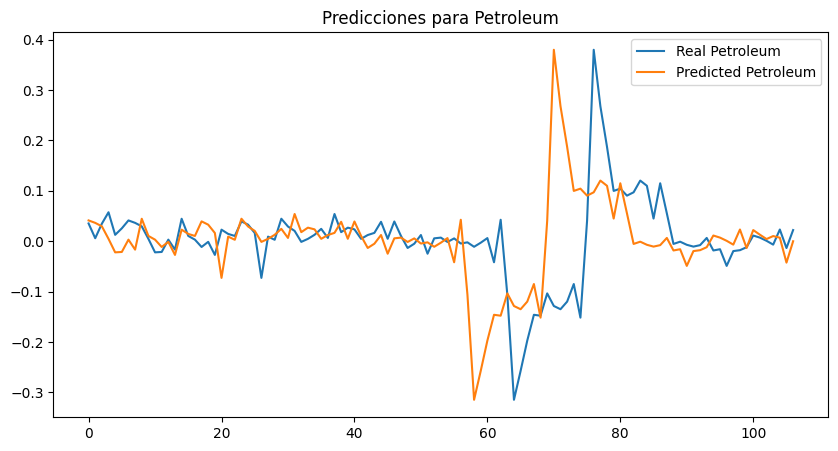

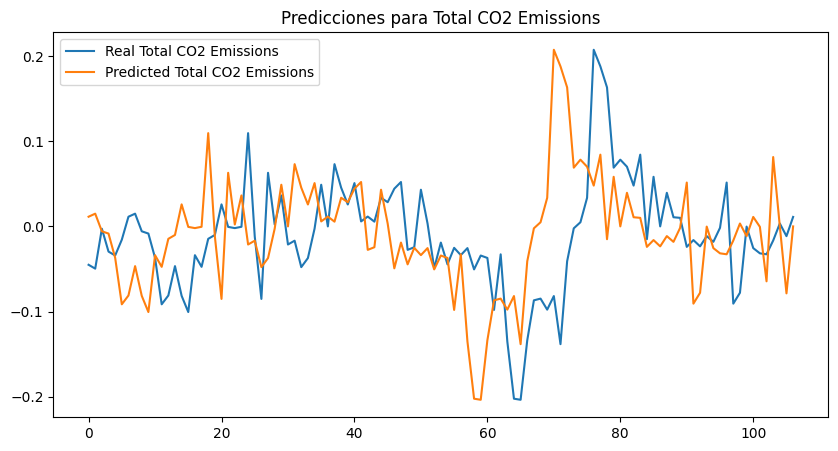

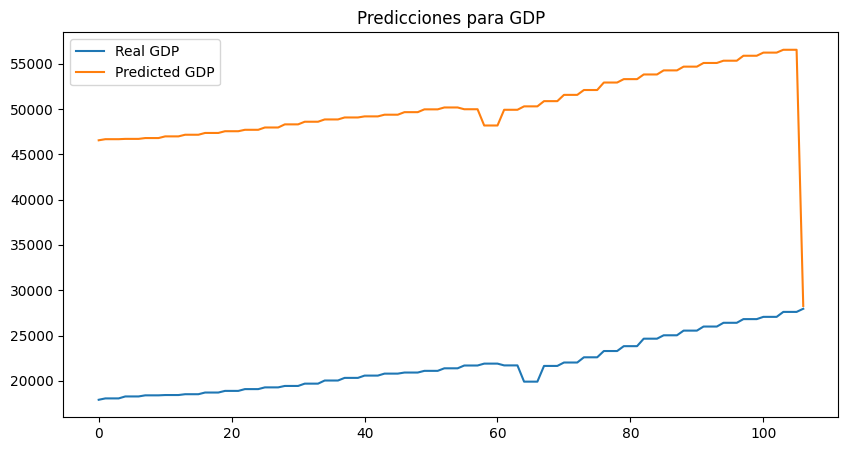

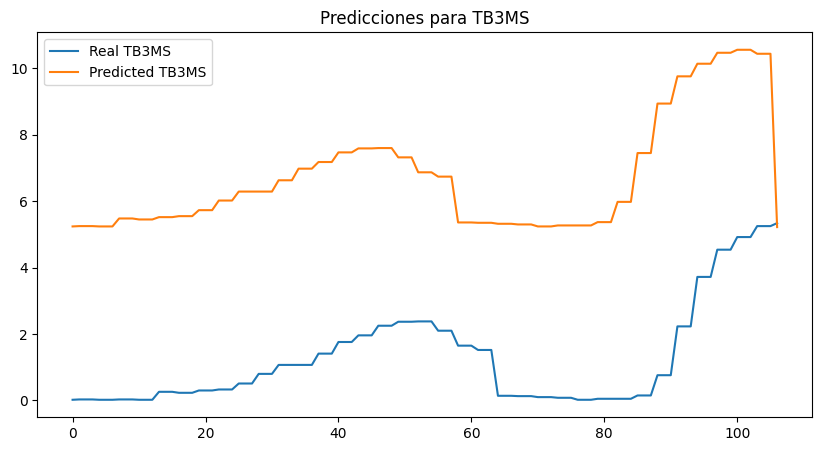

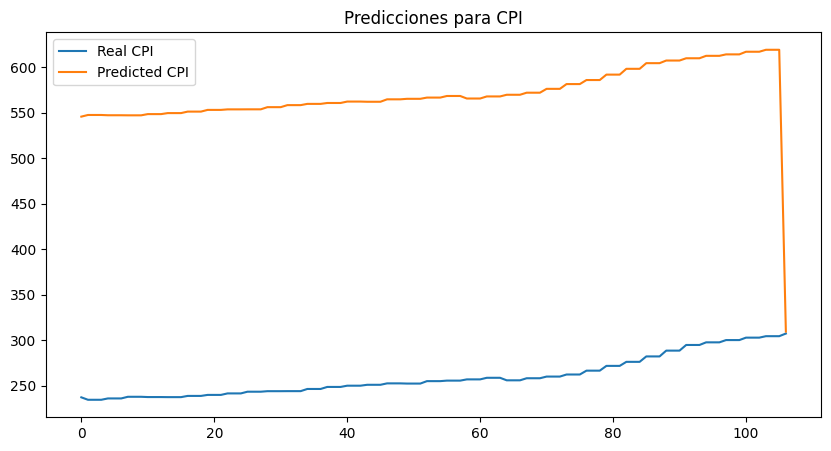

In [5]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

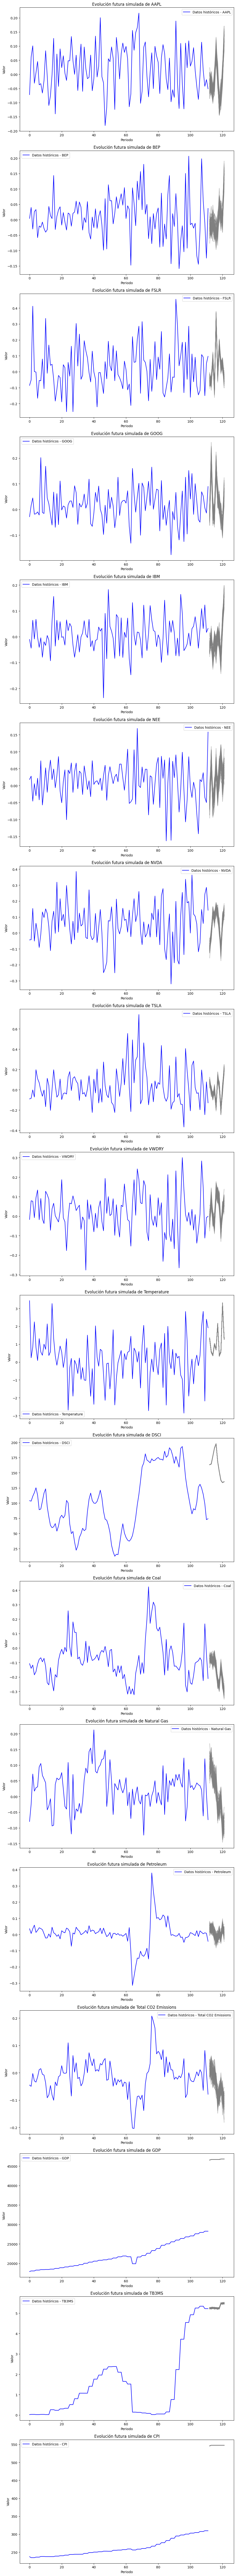

In [6]:
# Generar 100 escenarios para los próximos 10 periodos
scenarios = vr_model.simulate_scenarios(vr_results, lags=optimal_maxlags, n_scenarios=100, periods=10, noise_std=0.02)

# Graficar los resultados para cada variable no financiera, incluyendo datos históricos
n_variables = vr_model.neqs

fig, axs = plt.subplots(n_variables, 1, figsize=(10, 6 * n_variables))

for var_idx, var_name in enumerate(vr_model.endog.columns):
    
    # Graficar datos históricos
    axs[var_idx].plot(vr_model.endog.index, vr_model.endog.iloc[:, var_idx], label=f'Datos históricos - {var_name}', color='blue')
    
    # Graficar escenarios futuros
    for scenario in range(100):
        axs[var_idx].plot(range(len(vr_model.endog), len(vr_model.endog) + 10), scenarios[var_name][:, scenario], color='gray', alpha=0.5)
    
    axs[var_idx].set_title(f'Evolución futura simulada de {var_name}')
    axs[var_idx].set_xlabel('Periodo')
    axs[var_idx].set_ylabel('Valor')
    axs[var_idx].legend()

plt.tight_layout()
plt.show()

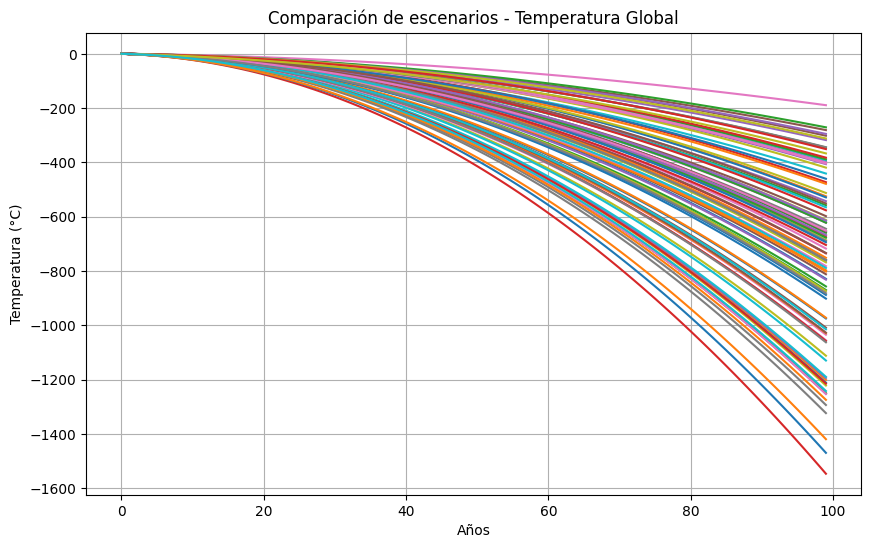

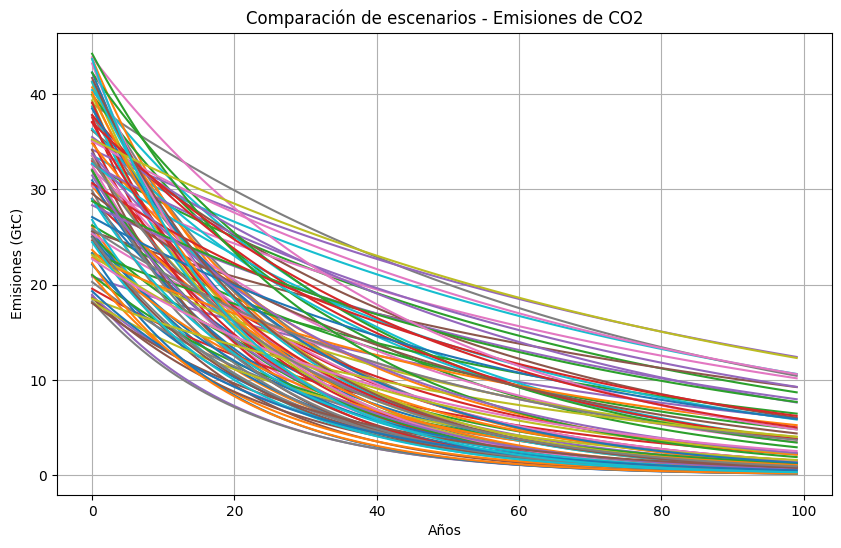

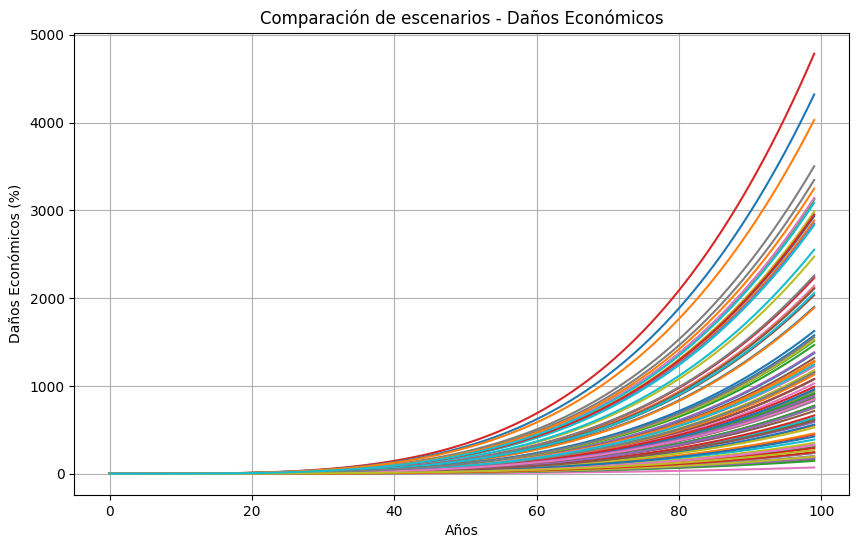

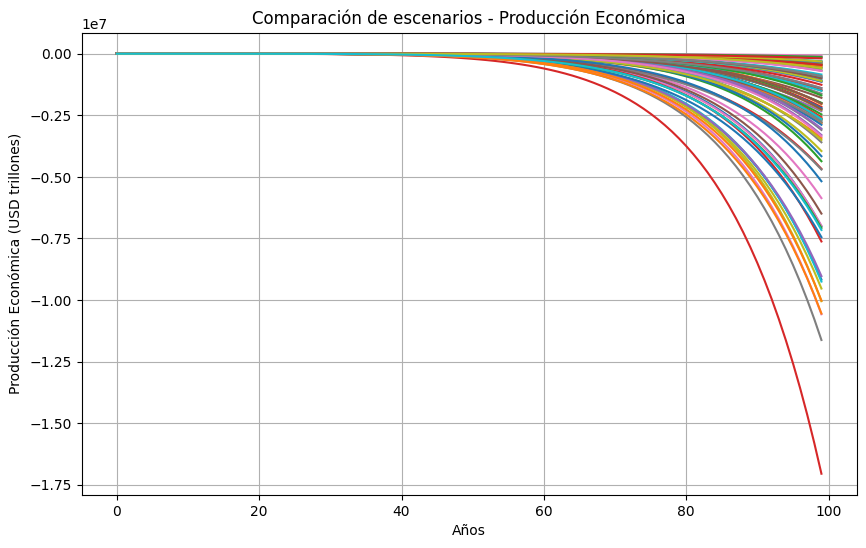

In [7]:
scenario_dice_model = ScenarioDICE()

num_scenarios = 100
scenarios = scenario_dice_model.generate_random_scenarios(num_scenarios=num_scenarios)

simulation_results = scenario_dice_model.simulate_multiple_scenarios(scenarios=scenarios, years=100)

scenario_dice_model.plot_scenarios(simulation_results)

In [10]:
# Alinear asset_prices y benchmark_prices según el índice (fechas o índices comunes)
asset_prices, benchmark_prices = asset_prices.align(benchmark_prices, join='inner', axis=0)

# Inicializar el optimizador de portafolios
optimizer = PortfolioOptimizer(asset_prices=asset_prices, risk_free_rate=rf, benchmark_prices=benchmark_prices)
num_portfolios = 10000
strategies = ['sharpe', 'omega', 'sortino']  # Puedes elegir las estrategias que quieras

# Optimizar el portafolio utilizando múltiples estrategias
optimal_portfolios = optimizer.optimize_with_multiple_strategies(num_portfolios=num_portfolios, strategies=strategies)

# Diccionario para almacenar los datos de portafolios
portfolios_data = {
    'strategy': [],
    'portfolio': [],
    'weights': [],
    'score': [],
    'jensen_alpha': [],
    'adjusted_return': []
}

# Iterar sobre las estrategias y los portafolios optimizados
for strategy, portfolios in optimal_portfolios.items():
    for i, (weights, score, adjusted_return) in enumerate(portfolios[:5]):  # Muestra los 5 mejores portafolios
        # Calcular Jensen's Alpha
        jensen_alpha = optimizer.calculate_jensen_alpha(weights)

        # Añadir los resultados al diccionario
        portfolios_data['strategy'].append(strategy)
        portfolios_data['portfolio'].append(f'Portafolio {i+1}')
        portfolios_data['weights'].append(weights)
        portfolios_data['score'].append(score)
        portfolios_data['jensen_alpha'].append(jensen_alpha)
        portfolios_data['adjusted_return'].append(adjusted_return)

# Convertir el diccionario en un DataFrame
portfolios_df = pd.DataFrame(portfolios_data)

# Imprimir todos los portafolios
portfolios_df



strategy     portfolio                                            weights  \
0    sharpe  Portafolio 1  [0.029542601871216354, 0.013845250578010167, 0...   
1    sharpe  Portafolio 2  [0.02897485173812088, 0.013765786517098047, 0....   
2    sharpe  Portafolio 3  [0.02265891376957249, 0.0025755990084489508, 0...   
3    sharpe  Portafolio 4  [0.07361728871496241, 0.0456788337587578, 0.04...   
4    sharpe  Portafolio 5  [0.02733012298899958, 0.2615065304340168, 0.07...   
5     omega  Portafolio 1  [0.08437439132144736, 0.21239116404436614, 0.1...   
6     omega  Portafolio 2  [0.06117174273779747, 0.24010308754755802, 0.1...   
7     omega  Portafolio 3  [0.06492592193159948, 0.2597795155769078, 0.03...   
8     omega  Portafolio 4  [0.044360080874946646, 0.23428635573766526, 0....   
9     omega  Portafolio 5  [0.10952375918335068, 0.033723206751887516, 0....   
10  sortino  Portafolio 1  [0.13356701344401567, 0.22380789310268423, 0.0...   
11  sortino  Portafolio 2  [0.03364986329185129, 0.09587364023986507, 0.0...   
12  sortino  Portafolio 3  [0.15593356649658588, 0.12085669629067604, 0.0...   
13  sortino  Portafolio 4  [0.10208867631247039, 0.1251712925348818, 0.05...   
14  sortino  Portafolio 5  [0.05518492685216823, 0.1428821125732159, 0.01...   

       score  jensen_alpha                                    adjusted_return  
0  -0.299365      0.056127  [-0.04704482621840392, -0.023008527340678847, ...  
1  -0.323717      0.053578  [-0.05547141600925075, -0.037606635722266725, ...  
2  -0.327818      0.049791  [-0.04710374875258713, -0.02542163918372572, 0...  
3  -0.340510      0.052157  [-0.049218767492611074, -0.027635207742546408,...  
4  -0.347733      0.047717  [-0.047521976784618745, -0.026342641392979642,...  
5  -1.433952      0.002990  [-0.01926854687913813, 0.011409857691428143, 0...  
6  -1.440597      0.003376  [-0.019103619918286647, 0.0156279918470551, 0....  
7  -1.442615     -0.003835  [-0.007221293124186088, 0.03014959258353711, 0...  
8  -1.453273      0.004319  [-0.01828419718605519, 0.01642870014816869, 0....  
9  -1.471745      0.009851  [-0.028344542683112317, 0.01241746087609483, 0...  
10  0.682851      0.001255  [-0.016523332516438612, 0.012256546259277393, ...  
11  0.681938     -0.000333  [-0.011972094708709342, 0.01872640699409007, 0...  
12  0.681676     -0.001904  [-0.01534894489306907, 0.011978643031307464, 0...  
13  0.679432      0.000997  [-0.018235566043910426, 0.006218778547306595, ...  
14  0.676993      0.001511  [-0.015155446111039254, -0.0071799713921823875...

In [16]:
best_portfolio = portfolios_df.loc[portfolios_df['score'].idxmax()]

average_return = np.mean(best_portfolio['adjusted_return'])

# Imprimir el mejor portafolio con su retorno promedio

print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")
best_portfolio


Retorno promedio del mejor portafolio: 0.0148


strategy                                                     sortino
portfolio                                               Portafolio 1
weights            [0.13356701344401567, 0.22380789310268423, 0.0...
score                                                       0.682851
jensen_alpha                                                0.001255
adjusted_return    [-0.016523332516438612, 0.012256546259277393, ...
Name: 10, dtype: object